In [2]:
#-*- coding:utf-8 -*-
from numpy import *
import numpy as np
import matplotlib.pyplot as plt
# 三大步骤：
'''
1、特征的选择：标准：总方差最小
2、回归树的生成：停止划分的标准
3、剪枝：
'''

# 导入数据集
def loadData(filaName):
    dataSet = []
    fr = open(filaName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        theLine = list(map(float, curLine))                 # map all elements to float()
        dataSet.append(theLine)
    return dataSet

# 特征选择：输入：       输出：最佳特征、最佳划分值
'''
1、选择标准
遍历所有的特征Fi：遍历每个特征的所有特征值Zi；找到Zi,划分后总的方差最小
停止划分的条件：
1、当前数据集中的标签相同，返回当前的标签
2、划分前后的总方差差距很小，数据不划分，返回的属性为空，返回的最佳划分值为当前所有标签的均值。
3、划分后的左右两个数据集的样本数量较小，返回的属性为空，返回的最佳划分值为当前所有标签的均值。
当划分的数据集满足上述条件之一，返回的最佳划分值作为叶子节点；
当划分后的数据集不满足上述要求时，找到最佳划分的属性，及最佳划分特征值
'''

# 计算总的方差
def GetAllVar(dataSet):
    return var(dataSet[:,-1])*shape(dataSet)[0]

# 根据给定的特征、特征值划分数据集
def dataSplit(dataSet,feature,featNumber):
    dataL =  dataSet[nonzero(dataSet[:,feature] > featNumber)[0],:]
    dataR = dataSet[nonzero(dataSet[:,feature] <= featNumber)[0],:]
    return dataL,dataR

# 特征划分
def choseBestFeature(dataSet,op = [1,4]):          # 三个停止条件可否当作是三个预剪枝操作
    if len(set(dataSet[:,-1].T.tolist()[0]))==1:     # 停止条件 1
        regLeaf = mean(dataSet[:,-1])
        return None,regLeaf                   # 返回标签的均值作为叶子节点
    Serror = GetAllVar(dataSet)
    BestFeature = -1; BestNumber = 0; lowError = inf
    m,n = shape(dataSet) # m 个样本， n -1 个特征
    for i in range(n-1):    # 遍历每一个特征值
        for j in set(dataSet[:,i].T.tolist()[0]):
            dataL,dataR = dataSplit(dataSet,i,j)
            if shape(dataR)[0]<op[1] or shape(dataL)[0]<op[1]: continue  # 如果所给的划分后的数据集中样本数目甚少，则直接跳出
            tempError = GetAllVar(dataL) + GetAllVar(dataR)
            if tempError < lowError:
                lowError = tempError; BestFeature = i; BestNumber = j
    if Serror - lowError < op[0]:               # 停止条件 2   如果所给的数据划分前后的差别不大，则停止划分
        return None,mean(dataSet[:,-1])
    dataL, dataR = dataSplit(dataSet, BestFeature, BestNumber)
    if shape(dataR)[0] < op[1] or shape(dataL)[0] < op[1]:        # 停止条件 3
        return None, mean(dataSet[:, -1])
    return BestFeature,BestNumber


# 决策树生成
def createTree(dataSet,op=[1,4]):
    bestFeat,bestNumber = choseBestFeature(dataSet,op)
    if bestFeat==None: return bestNumber
    regTree = {}
    regTree['spInd'] = bestFeat
    regTree['spVal'] = bestNumber
    dataL,dataR = dataSplit(dataSet,bestFeat,bestNumber)
    regTree['left'] = createTree(dataL,op)
    regTree['right'] = createTree(dataR,op)
    return  regTree

# 后剪枝操作
# 用于判断所给的节点是否是叶子节点
def isTree(Tree):
    return (type(Tree).__name__=='dict' )

# 计算两个叶子节点的均值
def getMean(Tree):
    if isTree(Tree['left']): Tree['left'] = getMean(Tree['left'])
    if isTree(Tree['right']):Tree['right'] = getMean(Tree['right'])
    return (Tree['left']+ Tree['right'])/2.0

# 后剪枝
def pruneTree(Tree,testData):
    if shape(testData)[0]==0: return getMean(Tree)
    if isTree(Tree['left'])or isTree(Tree['right']):
        dataL,dataR = dataSplit(testData,Tree['spInd'],Tree['spVal'])
    if isTree(Tree['left']):
        Tree['left'] = pruneTree(Tree['left'],dataL)
    if isTree(Tree['right']):
        Tree['right'] = pruneTree(Tree['right'],dataR)
    if not isTree(Tree['left']) and not isTree(Tree['right']):
        dataL,dataR = dataSplit(testData,Tree['spInd'],Tree['spVal'])
        errorNoMerge = sum(power(dataL[:,-1] - Tree['left'],2)) + sum(power(dataR[:,-1] - Tree['right'],2))
        leafMean = getMean(Tree)
        errorMerge = sum(power(testData[:,-1]-  leafMean,2))
        if errorNoMerge > errorMerge:
            print("the leaf merge")
            return leafMean
        else:
            return Tree
    else:
        return Tree

# 预测
def forecastSample(Tree,testData):
    if not isTree(Tree): return float(tree)
    # print"选择的特征是：" ,Tree['spInd']
    # print"测试数据的特征值是：" ,testData[Tree['spInd']]
    if testData[0,Tree['spInd']]>Tree['spVal']:
        if isTree(Tree['left']):
            return forecastSample(Tree['left'],testData)
        else:
            return float(Tree['left'])
    else:
        if isTree(Tree['right']):
            return forecastSample(Tree['right'],testData)
        else:
            return float(Tree['right'])

def TreeForecast(Tree,testData):
    m = shape(testData)[0]
    y_hat = mat(zeros((m,1)))
    for i in range(m):
        y_hat[i,0] = forecastSample(Tree,testData[i])
    return y_hat

if __name__=="__main__":
    print ("hello world")
    from sklearn.datasets import load_boston
    from sklearn.cross_validation import train_test_split

    data = load_boston()
    X_train, X_test, y_train, y_test = train_test_split(data.data, data.target,test_size=0.3)
    

hello world


In [4]:
y_train

array([25. , 23.9, 38.7, 20.4, 13.8, 13.8, 10.2, 20.5, 10.4, 17.4, 17.8,
       17.1, 24.1, 16.7, 16.3, 11.9, 24.1, 14.5, 13.4, 30.7, 42.8, 25.2,
       37.6, 29.1, 22.9, 34.9, 26.2, 31.5, 36.2, 25.1, 20.6, 13.4, 23.3,
       43.5, 20.6, 30.1, 10.5, 33.4, 11. , 34.9, 15. , 20. , 20.4, 16.1,
       22.6, 32.2, 10.8, 32.5, 50. , 21.7, 23.1, 19.5, 24.8, 20.5, 16. ,
       26.6, 28.6, 11.7, 10.5, 31.6, 30.8, 25. , 18.9, 22.5, 13.3, 21.1,
       16.1, 25. , 16.5, 21.1, 19.6, 19.6, 23. , 15. , 14.1, 23.7, 28.7,
       13.3, 13.8,  8.4, 33.4, 23.3, 19. , 24.1, 10.9, 13.4, 18. , 29. ,
       19.7,  6.3, 31.5, 17.5, 50. , 18.6, 39.8, 12.8, 23.6, 22. , 13.9,
       50. , 15.4, 13.5, 14.9, 18.9, 19.4, 23.7, 14.4, 31. , 26.6,  8.7,
       19.4, 22.6,  7.2, 20.8, 19.3, 48.3,  8.4, 19.4, 50. ,  9.6,  8.8,
       29.8, 50. , 19.5, 28.4, 18.5, 29.6, 36. , 23.8, 28.2, 18.6, 22.9,
       26.4, 32.4, 22. , 21.8, 29.6, 11.3, 18.5, 22.3, 36.2, 16.1, 37.2,
       20.5, 14.9,  5.6, 22.2, 15.4, 21.7, 19.8, 27

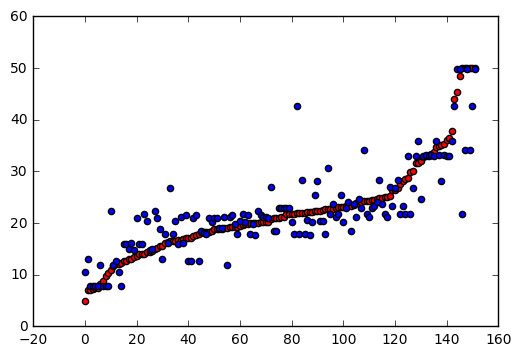

0.8533133224483429


In [6]:
    datatrain=np.concatenate((X_train,y_train[:,np.newaxis]),axis=1)
    dataMat = mat(datatrain)
    op = [1,6]    # 参数1：剪枝前总方差与剪枝后总方差差值的最小值；参数2：将数据集划分为两个子数据集后，子数据集中的样本的最少数量；
    theCreateTree =  createTree(dataMat,op)
   # 测试数据
    datatest = np.concatenate((X_test, y_test[:, np.newaxis]), axis=1)
    dataMat2=datatest[np.lexsort(datatest.T)]
    dataMat2 = mat(dataMat2)

    #thePruneTree =  pruneTree(theCreateTree, dataMat2)
    #print"剪枝后的后树：\n",thePruneTree
    y = dataMat2[:, -1]

    y_hat = TreeForecast(theCreateTree,dataMat2)
    plt.scatter(range(0, len(y)),y,c = 'r')
    plt.scatter(range(0, len(y_hat)), y_hat,c = 'b')
    plt.show()
    print (corrcoef(y_hat,y,rowvar=0)[0,1])